In [1]:
import pandas as pd
import numpy as np
import random
import math
from gravity_utils import *
import json
from datetime import timedelta as td
from datetime import time
from datetime import datetime
from matplotlib.pyplot import plot

import sys
sys.path.insert(1, '../DRTsim')
import utils, const
from utils import Activity, Coord
from const import ActivityType
from shapely.geometry import Point
import shapely.wkt

# Time distribution

In [2]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
resfil_raw = resfil_raw.loc[:, ['rf2_starttid','individvikt', 'ärende_2', 'Id', 'rf6_ankomsttid']]
#df_resfil = df_resfil[df_resfil['ärende_2']==1]
upsampled_resfil = draw_population(resfil_raw, resfil_raw.individvikt.astype(int))

## Work length distribution

In [3]:
def get_time_distr(resfil):
    times_binned = pd.cut(resfil.time_int, pd.interval_range(start=0, end=24, freq=0.25, closed='left'))
    time_distribution_raw = times_binned.value_counts().sort_index().values
    return pd.DataFrame(np.convolve(time_distribution_raw, np.ones((4,))/4, mode='same'), \
                          index=times_binned.cat.categories, columns=['total'])

In [4]:
resfil_time_length = resfil_raw[(resfil_raw['ärende_2'] == 1) | (resfil_raw['ärende_2'] == 10)]

In [5]:
resfil_time_length = resfil_time_length.dropna()
resfil_time_length

,rf2_starttid,individvikt,ärende_2,Id,rf6_ankomsttid
5,14:19,22.281823,10.0,1000116.0,15:40
9,12:30,10.434358,10.0,1000207.0,13:09
11,16:45,10.434358,10.0,1000207.0,16:55
16,7:00,93.653602,1.0,1000413.0,7:20
17,16:00,93.653602,10.0,1000413.0,16:20
24,7:00,50.622607,1.0,1000561.0,8:15
27,12:10,52.386774,10.0,1000629.0,12:40
31,09:47,61.311805,10.0,1000637.0,09:52
32,6:45,60.253098,1.0,1000645.0,6:52
33,14:35,60.253098,10.0,1000645.0,14:42


In [6]:
resfil_time_length = resfil_time_length.set_index('Id')

In [7]:
resfil_time_length.loc[:, 'rf2_starttid'] = resfil_time_length.rf2_starttid.replace({'99': np.NaN,
                                                                          '18.45': '18:45',
                                                                          '1900-': '19:00',
                                                                          '1 9:4': '19:4'})

resfil_time_length.loc[:, 'rf6_ankomsttid'] = resfil_time_length.rf6_ankomsttid.replace({'99': np.NaN,
                                                                          '18.45': '18:45',
                                                                          '1900-': '19:00',
                                                                          '1 9:4': '19:4'})

resfil_time_length = resfil_time_length.dropna()

In [8]:
d = []
i = []
w = []
for ind in resfil_time_length.index:
    x = resfil_time_length.loc[ind]
    if len(x) > 2:
        continue
    if 10 not in x['ärende_2'].values or 1 not in x['ärende_2'].values:
        continue

    
    start_time = x[x['ärende_2'] == 1]['rf6_ankomsttid']
    end_time = x[x['ärende_2'] == 10]['rf2_starttid']
    
    s = start_time.values[0].split(':')
    start_time = datetime(year = 1970, month = 1 ,day = 1,hour = int(s[0]), minute = int(s[1]))
    
    e = end_time.values[0].split(':')
    end_time = datetime(year = 1970, month = 1 ,day = 1,hour = int(e[0]), minute = int(e[1]))
    
    d.append(abs(end_time - start_time))
    i.append(ind)
    w.append(x['individvikt'].values[0])
work_length = pd.DataFrame(data=[i,d,w])

In [9]:
work_length = work_length.T
work_length.columns = ['Id', 'time', 'weight']

In [10]:
work_length['time_int'] = work_length.time.apply(lambda x: x.seconds / 3600)

In [11]:
upsampled_wl = draw_population(work_length, work_length.weight.astype(int))

In [12]:
work_length_distribution = get_time_distr(upsampled_wl)

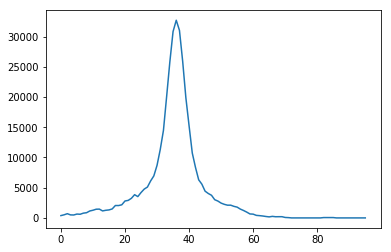

In [13]:
plot(work_length_distribution.total.values)

In [14]:
work_length_distribution.idxmax()

total    [9.0, 9.25)
dtype: object

## trip start distribution

In [15]:
upsampled_resfil.loc[:, 'rf2_starttid'] = upsampled_resfil.rf2_starttid.replace({'99': np.NaN,
                                                                          '18.45': '18:45',
                                                                          '1900-': '19:00',
                                                                          '1 9:4': '19:4'})
upsampled_resfil = upsampled_resfil.dropna()

/home/ai6644/.local/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
upsampled_resfil['minute'] = np.NaN
upsampled_resfil['hour'] = np.NaN

In [17]:
upsampled_resfil['time'] = upsampled_resfil.rf2_starttid.astype(str).apply(lambda x: x.split(':')).values

In [18]:
upsampled_resfil.loc[:, ['hour']] = upsampled_resfil['time'].apply(lambda x: x[0])
upsampled_resfil.loc[:, ['hour']] = upsampled_resfil.hour.astype(int)
upsampled_resfil.loc[:, ['minute']] = upsampled_resfil['time'].apply(lambda x: x[1])
upsampled_resfil.loc[:, ['minute']] = upsampled_resfil.minute.astype(int)

In [19]:
upsampled_resfil['time_int'] = upsampled_resfil.hour + (upsampled_resfil.minute / 60.)

In [20]:
comm_time_distribution = get_time_distr(upsampled_resfil)

In [21]:
comm_time_distribution.head()

,total
"[0.0, 0.25)",655.00
"[0.25, 0.5)",862.25
"[0.5, 0.75)",961.50
"[0.75, 1.0)",951.00
"[1.0, 1.25)",880.00


In [22]:
work_time_distribution = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == 1])
school_time_distribution = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == 2])
home_time_distribution = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == 10])

In [23]:
#plot(comm_time_distribution.total.values)
#plot(work_time_distribution.total.values)
#plot(school_time_distribution.total.values)
#plot(home_time_distribution.total.values)

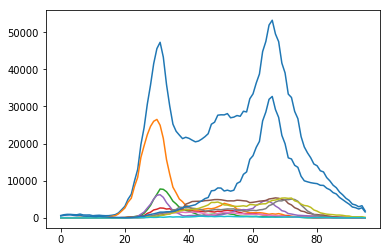

In [24]:
plot(comm_time_distribution.total.values)
for i in range(1,11):
    distr = get_time_distr(upsampled_resfil[upsampled_resfil['ärende_2'] == i])
    plot(distr.values)

# Data preparation

In [2]:
a2_ruta = pd.read_csv('data/GIS/a2_ruta_zone_codes.csv', sep=';', index_col=0)
a4_ruta = pd.read_csv('data/GIS/a4_ruta_zone_codes.csv', sep=';', index_col=0)

In [10]:
len(a2_ruta[(a2_ruta.zone >= 12650000) & (a2_ruta.zone <= 12700000)])

670

In [12]:
import geopandas

In [16]:
stops = geopandas.read_file('data/GIS/stations/stations.shp')
sams = geopandas.read_file('data/GIS/A2_samsSW_2012_shp/A2_sw_region.shp')

In [23]:
sjobo = sams[(sams.SAMSCODE >= '12650000') & (sams.SAMSCODE < '12660000')]

In [33]:
sjobo.to_crs(epsg=4326)

,SAMSCODE,Samsnamn,KOMMUN,Offentliga,Naringsliv,Totalt,geometry
682,12650008,Everlv,1265,128,354,482,"POLYGON ((13.58478058034333 55.63334801220672,..."
1138,12650014,Vollsj,1265,136,392,528,"POLYGON ((13.73515440914252 55.70505517299402,..."
1139,12650013,Frnninge,1265,106,366,472,(POLYGON ((13.77919469562624 55.77295656551625...
1141,12650011,Vanstad,1265,80,269,349,"POLYGON ((13.85434837986131 55.63965043000074,..."
1142,12650010,Vanstad,1265,24,104,128,"POLYGON ((13.79425998355591 55.60470153018342,..."
1143,12650009,Tolnga,1265,84,319,403,"POLYGON ((13.85834408184899 55.69826507783669,..."
1235,12650012,Lvestad,1265,132,473,605,"POLYGON ((13.89504225672151 55.71395731340065,..."
1592,12650017,stra Krrstorp,1265,85,253,338,"POLYGON ((13.72583314386401 55.74278474004563,..."
1593,12650016,stra Krrstorp,1265,43,105,148,"POLYGON ((13.61078302536589 55.72972908786937,..."
1594,12650015,Vollsj,1265,43,172,215,"POLYGON ((13.69477156586667 55.68911175484686,..."


In [35]:
sum(stops.within(sjobo.to_crs(epsg=4326).unary_union))

144

In [26]:
od_matrix = pd.read_csv('data/od_matrix.csv', sep=';', index_col=0)
od_matrix.iloc[0:1]

,1214,1230,1231,1233,1256,1257,1260,1261,1262,1263,...,12700011,12700012,12700013,12700014,12700015,12700016,12700017,12700018,12700019,12700020
1214,6138.29941,31.150788,71.925811,19.371292,2.376985,8.337177,685.316762,2645.21521,306.347163,12.306166,...,0.00441,0.004961,0.005549,0.001101,0.014959,0.012406,0.001678,0.000058,0.000041,0.000658


# Assigning building's position for persons

In [27]:
origin = od_matrix.index[0]
destination = int(od_matrix.loc[origin].sample(1, weights=od_matrix.loc[origin].values).index[0])
origin_ruta = a2_ruta[a2_ruta.zone == origin]
destionation_ruta = a4_ruta[a4_ruta.zone == destination]

In [28]:
class Population:
    def __init__(self):
        self.persons = []
    def to_JSON(self):
        return json.dumps(self, default=lambda o: _try(o), sort_keys=True, indent=4, separators=(',',':'))


class Person:
    def __init__(self):
        self.activities = []
        
#    def toJSON(self):
#        return json.dumps(self, default=lambda o: o.__dict__, 
#            sort_keys=True, indent=4)
        
    def to_JSON(self):
        return json.dumps(self, default=lambda o: _try(o), sort_keys=True, indent=4, separators=(',',':'))
        
def _try(o):
    try:
        if o.__class__ == ActivityType:
            raise Exception()
        return o.__dict__
    except:
        return str(o)

from enum import Enum
class ActivityType(Enum):
    HOME = 'HOME'
    WORK = 'WORK'

    def __str__(self):
        return self.name
    
class Activity(object):
    """Activity that is performed by a person.
    Person moves to a next activity after end_time is reached.

    Parameters
    ----------
    type_ : <ActivityType>
    coord : <Coord>
    start_time : <int> seconds from 00:00
    end_time : <int> seconds from 00:00
    """

    def __init__(self, type_, coord, start_time=None, end_time=None, zone=None):
        """docstring"""
        if start_time is None and end_time is None:
            raise Exception("Sanity check: both activity times are None")
        self.type = type_
        self.coord = coord
        self.start_time = start_time
        self.end_time = end_time
        self.zone = zone

    def __str__(self):
        return 'An ' + str(self.type) + ' at ' + str(self.coord)

In [29]:
def form_datetime(x):
    if type(x) == np.float64:
        m = (x - math.trunc(x)) * 60
        s = math.trunc((m - math.trunc(m)) * 60)
        m = math.trunc(m)
        h = math.trunc(x)
        return datetime(year = 1970, month = 1 ,day = 1, hour = h, minute=m, second = s)
    elif type(x) == time:
        return datetime(year = 1970, month = 1 ,day = 1, hour = x.hour, minute=x.minute, second = x.second)
    
def form_td(x):
    if type(x) == np.float64:
        m = (x - math.trunc(x)) * 60
        s = math.trunc((m - math.trunc(m)) * 60)
        m = math.trunc(m)
        h = math.trunc(x)
        return td(hours = h, minutes=m, seconds = s)
    elif type(x) == time:
        return td(hours = x.hour, minutes=x.minute, seconds = x.second)

In [30]:
datetime(year = 1970, month = 1 ,day = 1, hour = 23) + td(minutes=90)

datetime.datetime(1970, 1, 2, 0, 30)

In [31]:
a = datetime(year = 1970, month = 1 ,day = 1, hour = 23)
b = td(minutes=90)
(a + b).date()

datetime.date(1970, 1, 2)

In [32]:
datetime(year = 1970, month = 1 ,day = 1, hour = 1).time() < time(1,30)

True

# Main cycle

In [36]:
# time_window = td(minutes = 90)
# time_check = time(1, 30)

population = Population()

def sample_time(time_distr):
    time_bin = time_distr.sample(1, weights='total').index
    return form_datetime(random.uniform(time_bin.left, time_bin.right)[0]).time()

def form_activity(zone, act_type, 
                  coord=None, buildings=None, b_weights=None,
                  s_time=None, s_distr=None, 
                  e_time=None, e_distr=None, 
                  l_distr=None):
    """Combines an activity out of provided locations, type and times
    
    Parameters
    ----------
    coord: exact coordinate to set a position of activity
    buildings, b_weights: pd.Dataframe of buildings and weights to sample from activity
    s_time, s_distr: starting time or time distribution.
    e_time, e_distr: end time or distribution.
    l_distr: distribution of activity duration. Added to start time
    """
    if coord is not None:
        location = coord
    else:
        coord = shapely.wkt.loads(buildings.sample(n=1, weights=b_weights).geometry.values[0])
        location = Coord(lat=coord.y, lon=coord.x)
    
    if s_time is not None:
        start_time = s_time
    else:
        start_time = sample_time(s_distr)
        
    if e_time is not None:
        end_time = e_time
    elif l_distr is not None:
        end_time_tmp = form_datetime(start_time) + form_td(sample_time(l_distr))
        if end_time_tmp.date() != form_datetime(start_time).date():
            end_time = time(23,59,59)
        else:
            end_time = end_time_tmp.time()
    else:
        end_time = sample_time(e_distr)
        
    return Activity(act_type,
                   location,
                   start_time=start_time,
                   end_time=end_time,
                   zone=zone
                  )

for origin, destinations in od_matrix.iterrows():
    
    for destination, pop in destinations.iteritems():
        # only calculate persons that go to, from or within target zones         
        if int(origin) < 12650000 and int(destination) < 12650000:
            continue
        #destination = int(destinations.sample(1, weights=destinations.values).index[0])
        origin_ruta = a2_ruta[a2_ruta.zone == origin]
        destionation_ruta = a4_ruta[a4_ruta.zone == int(destination)]
        
        print(origin, destination, round(pop))
        for pers in range(round(pop)):
            new_pers = Person()
            
            # home activity
            act = form_activity(buildings = origin_ruta, 
                                b_weights = origin_ruta.Totalt,
                                zone =origin, 
                                act_type = ActivityType.HOME,
                                s_time = time(0),
                                e_distr = work_time_distribution)          
            new_pers.activities.append(act)
            
            # work activity            
            act = form_activity(buildings = destionation_ruta, 
                                b_weights = destionation_ruta.Totalt,
                                zone = destination, 
                                act_type = ActivityType.WORK,
                                s_time = new_pers.activities[-1].end_time,
                                l_distr = work_length_distribution)
            # make sure work is not in the same place
            # actually, I think it is OK, as to travel to the same RUTA            
#             while act.coord == new_pers.activities[-1].coord:
#                 act = form_activity(buildings = destionation_ruta,
#                                     b_weights = destionation_ruta.Totalt,
#                                     zone = int(destination), 
#                                     act_type = ActivityType.WORK,
#                                     s_time = new_pers.activities[-1].end_time,
#                                     l_distr = work_length_distribution)
            new_pers.activities.append(act)
            
            # back home activity
            act = form_activity(coord = new_pers.activities[0].coord, 
                    zone = origin, 
                    act_type = ActivityType.HOME,
                    s_time = new_pers.activities[-1].end_time,
                    e_time = time(23,59,59))
            new_pers.activities.append(act)
            
            population.persons.append(new_pers)
            

#        print(origin, destination, round(pop))
            
#        break
#    break
    

1214 12650001 0
1214 12650002 0
1214 12650003 0
1214 12650004 0
1214 12650005 0
1214 12650006 0
1214 12650007 0
1214 12650008 0
1214 12650009 0
1214 12650010 0
1214 12650011 0
1214 12650012 0
1214 12650013 0
1214 12650014 0
1214 12650015 0
1214 12650016 0
1214 12650017 0
1214 12700001 0
1214 12700002 0
1214 12700003 0
1214 12700004 0
1214 12700005 0
1214 12700006 0
1214 12700007 0
1214 12700008 0
1214 12700009 0
1214 12700010 0
1214 12700011 0
1214 12700012 0
1214 12700013 0
1214 12700014 0
1214 12700015 0
1214 12700016 0
1214 12700017 0
1214 12700018 0
1214 12700019 0
1214 12700020 0
1230 12650001 1
1230 12650002 0
1230 12650003 4
1230 12650004 5
1230 12650005 5
1230 12650006 1
1230 12650007 7
1230 12650008 4
1230 12650009 0
1230 12650010 0
1230 12650011 0
1230 12650012 0
1230 12650013 0
1230 12650014 1
1230 12650015 1
1230 12650016 0
1230 12650017 1
1230 12700001 0
1230 12700002 0
1230 12700003 0
1230 12700004 0
1230 12700005 1
1230 12700006 0
1230 12700007 0
1230 12700008 0
1230 127

1275 12700012 0
1275 12700013 0
1275 12700014 0
1275 12700015 0
1275 12700016 0
1275 12700017 0
1275 12700018 0
1275 12700019 0
1275 12700020 0
1276 12650001 0
1276 12650002 0
1276 12650003 0
1276 12650004 0
1276 12650005 0
1276 12650006 0
1276 12650007 0
1276 12650008 0
1276 12650009 0
1276 12650010 0
1276 12650011 0
1276 12650012 0
1276 12650013 0
1276 12650014 0
1276 12650015 0
1276 12650016 0
1276 12650017 0
1276 12700001 0
1276 12700002 0
1276 12700003 0
1276 12700004 0
1276 12700005 0
1276 12700006 0
1276 12700007 0
1276 12700008 0
1276 12700009 0
1276 12700010 0
1276 12700011 0
1276 12700012 0
1276 12700013 0
1276 12700014 0
1276 12700015 0
1276 12700016 0
1276 12700017 0
1276 12700018 0
1276 12700019 0
1276 12700020 0
1277 12650001 0
1277 12650002 0
1277 12650003 0
1277 12650004 0
1277 12650005 0
1277 12650006 0
1277 12650007 0
1277 12650008 0
1277 12650009 0
1277 12650010 0
1277 12650011 0
1277 12650012 0
1277 12650013 0
1277 12650014 0
1277 12650015 0
1277 12650016 0
1277 126

1292 12700017 0
1292 12700018 0
1292 12700019 0
1292 12700020 0
1293 12650001 0
1293 12650002 0
1293 12650003 1
1293 12650004 1
1293 12650005 1
1293 12650006 0
1293 12650007 0
1293 12650008 0
1293 12650009 0
1293 12650010 0
1293 12650011 0
1293 12650012 0
1293 12650013 1
1293 12650014 1
1293 12650015 0
1293 12650016 0
1293 12650017 1
1293 12700001 0
1293 12700002 0
1293 12700003 0
1293 12700004 0
1293 12700005 0
1293 12700006 0
1293 12700007 0
1293 12700008 0
1293 12700009 0
1293 12700010 0
1293 12700011 0
1293 12700012 0
1293 12700013 0
1293 12700014 0
1293 12700015 0
1293 12700016 1
1293 12700017 0
1293 12700018 0
1293 12700019 0
1293 12700020 0
12650001 1214 2
12650001 1230 69
12650001 1231 34
12650001 1233 14
12650001 1256 0
12650001 1257 0
12650001 1260 0
12650001 1261 6
12650001 1262 10
12650001 1263 9
12650001 1264 82
12650001 1266 86
12650001 1267 34
12650001 1272 1
12650001 1273 0
12650001 1275 0
12650001 1276 0
12650001 1277 0
12650001 1278 0
12650001 1280 395
12650001 1281 6

12650007 1231 55
12650007 1233 23
12650007 1256 0
12650007 1257 0
12650007 1260 0
12650007 1261 9
12650007 1262 16
12650007 1263 221
12650007 1264 679
12650007 1266 78
12650007 1267 31
12650007 1272 0
12650007 1273 0
12650007 1275 1
12650007 1276 0
12650007 1277 0
12650007 1278 0
12650007 1280 638
12650007 1281 1107
12650007 1282 4
12650007 1283 2
12650007 1284 0
12650007 1285 65
12650007 1286 1272
12650007 1287 175
12650007 1290 10
12650007 1291 15
12650007 1292 0
12650007 1293 16
12650007 12650001 8
12650007 12650002 2
12650007 12650003 32
12650007 12650004 43
12650007 12650005 41
12650007 12650006 13
12650007 12650007 132
12650007 12650008 48
12650007 12650009 3
12650007 12650010 1
12650007 12650011 1
12650007 12650012 5
12650007 12650013 4
12650007 12650014 6
12650007 12650015 4
12650007 12650016 2
12650007 12650017 3
12650007 12700001 1
12650007 12700002 0
12650007 12700003 1
12650007 12700004 2
12650007 12700005 6
12650007 12700006 4
12650007 12700007 1
12650007 12700008 0
126500

12650013 12650008 6
12650013 12650009 13
12650013 12650010 0
12650013 12650011 3
12650013 12650012 19
12650013 12650013 56
12650013 12650014 54
12650013 12650015 8
12650013 12650016 5
12650013 12650017 18
12650013 12700001 1
12650013 12700002 0
12650013 12700003 1
12650013 12700004 5
12650013 12700005 3
12650013 12700006 2
12650013 12700007 1
12650013 12700008 0
12650013 12700009 1
12650013 12700010 1
12650013 12700011 1
12650013 12700012 1
12650013 12700013 2
12650013 12700014 1
12650013 12700015 4
12650013 12700016 15
12650013 12700017 0
12650013 12700018 0
12650013 12700019 0
12650013 12700020 0
12650014 1214 8
12650014 1230 42
12650014 1231 21
12650014 1233 8
12650014 1256 2
12650014 1257 0
12650014 1260 0
12650014 1261 3
12650014 1262 6
12650014 1263 5
12650014 1264 49
12650014 1266 564
12650014 1267 225
12650014 1272 3
12650014 1273 1
12650014 1275 7
12650014 1276 0
12650014 1277 0
12650014 1278 0
12650014 1280 239
12650014 1281 414
12650014 1282 2
12650014 1283 1
12650014 1284 0

12700003 1267 6
12700003 1272 1
12700003 1273 0
12700003 1275 0
12700003 1276 0
12700003 1277 0
12700003 1278 0
12700003 1280 35
12700003 1281 61
12700003 1282 0
12700003 1283 0
12700003 1284 0
12700003 1285 4
12700003 1286 99
12700003 1287 4
12700003 1290 16
12700003 1291 70
12700003 1292 0
12700003 1293 1
12700003 12650001 1
12700003 12650002 0
12700003 12650003 8
12700003 12650004 11
12700003 12650005 10
12700003 12650006 2
12700003 12650007 4
12700003 12650008 2
12700003 12650009 2
12700003 12650010 2
12700003 12650011 3
12700003 12650012 5
12700003 12650013 1
12700003 12650014 1
12700003 12650015 1
12700003 12650016 0
12700003 12650017 1
12700003 12700001 5
12700003 12700002 1
12700003 12700003 4
12700003 12700004 9
12700003 12700005 28
12700003 12700006 17
12700003 12700007 6
12700003 12700008 1
12700003 12700009 3
12700003 12700010 3
12700003 12700011 4
12700003 12700012 5
12700003 12700013 0
12700003 12700014 1
12700003 12700015 0
12700003 12700016 4
12700003 12700017 2
1270000

12700009 12700002 1
12700009 12700003 5
12700009 12700004 17
12700009 12700005 45
12700009 12700006 25
12700009 12700007 9
12700009 12700008 6
12700009 12700009 16
12700009 12700010 19
12700009 12700011 15
12700009 12700012 14
12700009 12700013 3
12700009 12700014 8
12700009 12700015 4
12700009 12700016 29
12700009 12700017 5
12700009 12700018 1
12700009 12700019 0
12700009 12700020 1
12700010 1214 0
12700010 1230 7
12700010 1231 4
12700010 1233 1
12700010 1256 5
12700010 1257 0
12700010 1260 0
12700010 1261 1
12700010 1262 1
12700010 1263 9
12700010 1264 26
12700010 1266 17
12700010 1267 7
12700010 1272 7
12700010 1273 2
12700010 1275 0
12700010 1276 0
12700010 1277 0
12700010 1278 0
12700010 1280 42
12700010 1281 74
12700010 1282 0
12700010 1283 0
12700010 1284 0
12700010 1285 4
12700010 1286 164
12700010 1287 7
12700010 1290 154
12700010 1291 737
12700010 1292 0
12700010 1293 14
12700010 12650001 1
12700010 12650002 0
12700010 12650003 10
12700010 12650004 13
12700010 12650005 12
12

12700016 1281 32
12700016 1282 0
12700016 1283 0
12700016 1284 0
12700016 1285 2
12700016 1286 70
12700016 1287 3
12700016 1290 1220
12700016 1291 530
12700016 1292 0
12700016 1293 112
12700016 12650001 1
12700016 12650002 0
12700016 12650003 4
12700016 12650004 6
12700016 12650005 5
12700016 12650006 1
12700016 12650007 2
12700016 12650008 1
12700016 12650009 7
12700016 12650010 1
12700016 12650011 6
12700016 12650012 20
12700016 12650013 14
12700016 12650014 11
12700016 12650015 2
12700016 12650016 1
12700016 12650017 4
12700016 12700001 6
12700016 12700002 1
12700016 12700003 3
12700016 12700004 9
12700016 12700005 25
12700016 12700006 14
12700016 12700007 5
12700016 12700008 3
12700016 12700009 11
12700016 12700010 11
12700016 12700011 9
12700016 12700012 8
12700016 12700013 14
12700016 12700014 9
12700016 12700015 21
12700016 12700016 217
12700016 12700017 3
12700016 12700018 0
12700016 12700019 0
12700016 12700020 1
12700017 1214 0
12700017 1230 1
12700017 1231 0
12700017 1233 0


In [37]:
j = json.loads(population.to_JSON())

In [38]:
j

{'persons': [{'activities': [{'coord': {'lat': 55.63664917748375,
      'lon': 13.19096411368734},
     'end_time': '07:38:08',
     'start_time': '00:00:00',
     'type': 'HOME',
     'zone': 1230},
    {'coord': {'lat': 55.63147724126671, 'lon': 13.66378981301701},
     'end_time': '17:32:41',
     'start_time': '07:38:08',
     'type': 'WORK',
     'zone': '12650001'},
    {'coord': {'lat': 55.63664917748375, 'lon': 13.19096411368734},
     'end_time': '23:59:59',
     'start_time': '17:32:41',
     'type': 'HOME',
     'zone': 1230}]},
  {'activities': [{'coord': {'lat': 55.63446235998293,
      'lon': 13.19503672116646},
     'end_time': '08:11:07',
     'start_time': '00:00:00',
     'type': 'HOME',
     'zone': 1230},
    {'coord': {'lat': 55.63656159933529, 'lon': 13.71922010804078},
     'end_time': '16:26:29',
     'start_time': '08:11:07',
     'type': 'WORK',
     'zone': '12650003'},
    {'coord': {'lat': 55.63446235998293, 'lon': 13.19503672116646},
     'end_time': '23:5

In [40]:
with open('data/population_ruta.json', 'w') as outfile:
    json.dump(j, outfile)